In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.3


/home/lerko/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


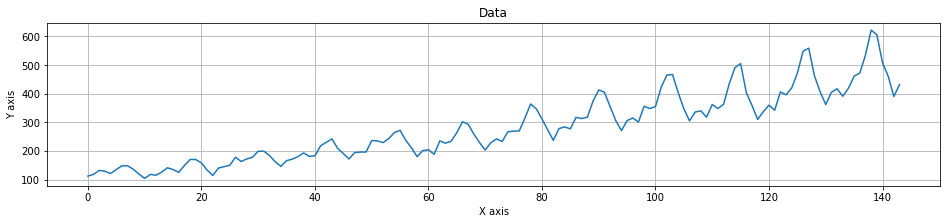

In [2]:
fileName = 'datosT1P2.txt'
data = np.loadtxt(fileName)

fig = plt.figure(0,(16,3))
plt.plot(data[:,0],data[:,1])
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.grid()
plt.show(fig)

Total data: 144
Train data: 108
Test data : 36


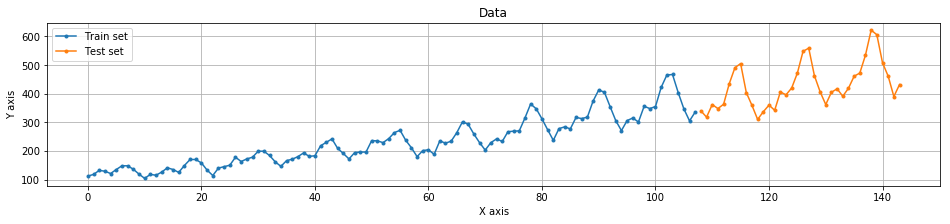

0.0 107.0
112.0 336.0


In [3]:

nData = data.shape[0]
nTrain = int(np.ceil(0.75*nData))

print('Total data: %i\nTrain data: %i\nTest data : %i' %(nData, nTrain, nData-nTrain))

train_set = data[0:nTrain,:]
test_set  = data[nTrain:,:]

fig = plt.figure(0,(16,3))
plt.plot(train_set[:,0],train_set[:,1],'.-')
plt.plot(test_set[:,0],test_set[:,1],'.-')
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend(('Train set', 'Test set'))
plt.grid()
plt.show(fig)

print(train_set[0,0],train_set[-1,0])
print(train_set[0,1],train_set[-1,1])

In [4]:
import theano.tensor as tt

grade = 3

k = np.linspace(0,grade,grade+1)
X = train_set[:,0]
print('X shape: %s' % X.shape)

Y = train_set[:,1]
print('Y shape: %s' % Y.shape)


basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    theta = pm.Normal('theta', mu=0, sd=100, shape = 4)
    # theta3 = pm.Normal('theta3', mu=0, sd=100)
    # sigma = pm.HalfNormal('sigma', sd=10)
    sigma = pm.HalfNormal('sigma_y', sd=200)

    # Expected value of outcome
    mu_obs = theta[3]+theta[2]*X#+theta[1]*np.power(X,2)#+theta[0]*np.power(X,3)
    # mu_obs = np.sum(np.dot(theta,X_aux),axis = 1)
    print('mu_obs shape: %s'% mu_obs.shape)
        
    # Model
    Y_obs = pm.Normal('Y_obs', mu=mu_obs, sd=sigma, observed=Y)
    
    ## sample using MEtropolis
    # step = pm.Metropolis()
    # trace = pm.sample(10000, step)

map_estimate = pm.find_MAP(model=basic_model)

print(map_estimate)

X shape: 108
Y shape: 108
mu_obs shape: Shape.0


logp = -564.92, ||grad|| = 0.91504: 100%|██████████| 36/36 [00:00<00:00, 3881.52it/s]


{'theta': array([ 0.        ,  0.        ,  2.49878632, 97.10382693]), 'sigma_y_log__': array(3.55134073), 'sigma_y': array(34.8600242)}


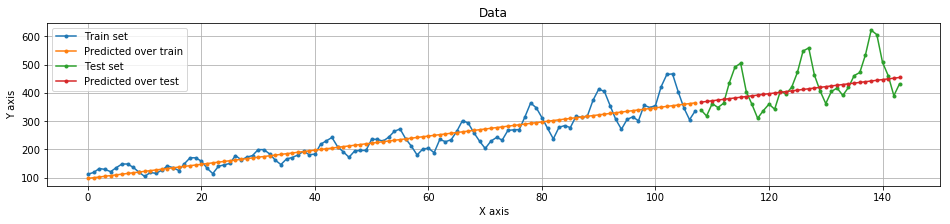

In [5]:
# theta = [float(map_estimate['theta1']),float(map_estimate['theta0'])]
theta = map_estimate['theta']
# theta = [float(map_estimate['theta3']), float(map_estimate['theta2']), float(map_estimate['theta1']),float(map_estimate['theta0'])]

X_test = test_set[:,0]
Y_test = test_set[:,1]

Y_train_hat_pol = np.polyval(theta,X)
Y_hat_pol = np.polyval(theta,X_test)

fig = plt.figure(0,(16,3))
plt.plot(X,Y,'.-')
plt.plot(X,Y_train_hat_pol,'.-')
plt.plot(X_test,Y_test,'.-')
plt.plot(X_test,Y_hat_pol ,'.-')
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend(('Train set', 'Predicted over train', 'Test set', 'Predicted over test'))
plt.grid()
# plt.savefig('final.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show(fig)

In [6]:
def f_pol_sin(x,a,b_list):
    out = np.polyval(a,x)
    
    for b in b_list:
        out += b[0]*np.sin(b[1]*x+b[2])*np.exp(b[3]*x)
        
    return out

In [17]:
import mle
import theano

theano.config.compute_test_value = 'ignore'


X = train_set[:,0]

print('X shape: %s' % X.shape)

Y = train_set[:,1]
print('Y shape: %s' % Y.shape)

numberOfBasis = 1
theta_sin_val = [np.asarray([0,0,0,0])]
init_values = [{'theta1': -11, 'theta2':1330, 'theta3': 80, 'theta4': 0.01, 'sigma': 1},
               {'theta1': 100, 'theta2': 120, 'theta3': 200, 'theta4': 0.1, 'sigma': 100}]

# Define model
x = mle.var('x', observed=True, vector=True)
y = mle.var('y', observed=True, vector=True)
sigma = mle.var('sigma')

for i in range(numberOfBasis):
    theta_sin = []
    for j in range(4):
        print('Creating {} model theta{}'.format(i,j+1))
        theta_sin.append(mle.var('theta{}'.format(j+1)))
        
    model = mle.Normal(y, f_pol_sin(X,theta,theta_sin_val) + theta_sin[0]*tt.sin(theta_sin[1]*x + theta_sin[2])*tt.exp(theta_sin[3]*x), sigma)
    print('init values: {}'.format(init_values[i]))
    result = model.fit({'x': X, 'y': Y}, init_values[i])
    
    theta_sin_val.append([float(result.x['theta1']), float(result.x['theta2']), float(result.x['theta3']),float(result.x['theta4'])])
    
    print(result)

X shape: 108
Y shape: 108
Creating 0 model theta1
Creating 0 model theta2
Creating 0 model theta3
Creating 0 model theta4
init values: {'theta1': -11, 'theta2': 1330, 'theta3': 80, 'theta4': 0.01, 'sigma': 1}
Optimization terminated successfully.
         Current function value: 536.713963
         Iterations: 33
         Function evaluations: 55
         Gradient evaluations: 55
 fit_time: 0.010556999999998595
      fun: 536.7139629998702
 hess_inv: array([[ 5.59307300e+00,  7.06637827e+00, -1.91580910e+02,
         2.11139290e-02, -6.15086598e+00],
       [ 7.06637827e+00,  9.91477363e+00, -2.42033810e+02,
         1.62153697e-02, -7.76928867e+00],
       [-1.91580910e+02, -2.42033810e+02,  6.56321633e+03,
        -7.44928290e-01,  2.10718819e+02],
       [ 2.11139290e-02,  1.62153697e-02, -7.44928290e-01,
         2.40308481e-01, -2.37257931e-02],
       [-6.15086598e+00, -7.76928867e+00,  2.10718819e+02,
        -2.37257931e-02,  6.76534932e+00]])
      jac: array([-2.41644250e-06,

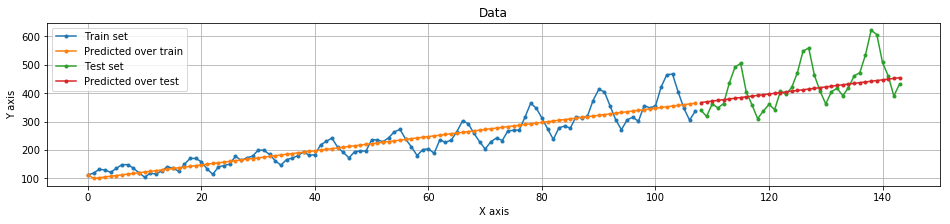

In [18]:
X_test = test_set[:,0]
Y_test = test_set[:,1]

Y_train_hat_polsin = f_pol_sin(X,theta,theta_sin_val)
Y_hat_polsin = f_pol_sin(X_test,theta,theta_sin_val)

fig = plt.figure(0,(16,3))
plt.plot(X,Y,'.-')
plt.plot(X,Y_train_hat_polsin,'.-')
plt.plot(X_test,Y_test,'.-')
plt.plot(X_test,Y_hat_polsin ,'.-')
plt.title('Data')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend(('Train set', 'Predicted over train', 'Test set', 'Predicted over test'))
plt.grid()
plt.savefig('final.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show(fig)